In [1]:
pip install datasets transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machin

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

2025-05-10 11:00:50.855916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746874851.044837      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746874851.099232      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [49]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 3

In [50]:
def load_video_frames(video_folder):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [51]:
import pandas as pd
df = pd.read_csv("/kaggle/input/train.csv")
tdf = pd.read_csv("/kaggle/input/test.csv")
df

,file_id,text,source,category,class
0,3562022343909810991_63576812758,[NULL],Instagram,Safe,Safe
1,956326452811210,আমেরিকার ছাত্র আন্দোলন দমনের একটা দুর্লভ ফুটেজ,Facebook,Unsafe,Harmful
2,1621007965265006,গ্রামের সুন্দরী মেয়েদের সুন্দর ড্যান্স,Facebook,Unsafe,Adult
3,3382687520997377089_66846781731,[NULL],Instagram,Unsafe,Adult
4,507863908972262,ছেলেটার আজ আর বাড়ী যাওয়া হল না ময়মনসিংহ,Facebook,Safe,Safe
...,...,...,...,...,...
1531,1055274349411417,"শক্তি নাইরে বুড়ার গায়ে, তেল মাখতে হয় পায়ে। ওরে...",Facebook,Unsafe,Adult
1532,854716976272203,[NULL],Facebook,Safe,Safe
1533,3552382770196940051_63576812758,[NULL],Instagram,Safe,Safe
1534,6758856234238228,[NULL],Facebook,Unsafe,Adult


In [52]:
df = df[df['category']=='Unsafe']
tdf = tdf[tdf['category']=='Unsafe']

In [53]:
tdf['class'].value_counts()

class
Adult       94
Harmful     64
Suicidal    55
Name: count, dtype: int64

In [54]:
df['class'].value_counts()

class
Adult       373
Harmful     257
Suicidal    221
Name: count, dtype: int64

In [55]:
id2label = {
    "Adult": 0,
    "Harmful": 1,
    "Suicidal": 2
}

In [56]:
df['class'] = df['class'].map(id2label)
tdf['class'] = tdf['class'].map(id2label)

/tmp/ipykernel_31/376236088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class'].map(id2label)


In [57]:
dir1 = "/kaggle/input/Video/Video"
dir2 = "/kaggle/input/UNBER_IG/UNBER_IG/Video_IG"

In [58]:
def extract(df, c):
    X_video = []
    y = []
    
    for _, row in df.iterrows():
        reel_id = row["file_id"] 
        label = row["class"]  
    
        for dir in [dir1, dir2]:
            video_folder = os.path.join(dir, reel_id)
            if os.path.isdir(video_folder):
                frames = load_video_frames(video_folder)
    
                # Fix the frame count to exactly 15
                if frames.shape[0] < c:
                    # Pad with last frame
                    pad_count = c - frames.shape[0]
                    last_frame = frames[-1:]
                    pad_frames = np.repeat(last_frame, pad_count, axis=0)
                    frames = np.concatenate([frames, pad_frames], axis=0)
                elif frames.shape[0] > c:
                    # Truncate extra frames
                    frames = frames[:c]
    
                if frames.shape == (c, 224, 224, 3):
                    X_video.append(frames)
                    y.append(label)
                else:
                    print(reel_id, "Shape mismatch:", frames.shape)

    X_video = np.array(X_video)  
    y = np.array(y)
    print(X_video.shape)
    print(y.shape)
    return X_video, y

In [59]:
X_video, y = extract(df, 5)

(851, 5, 224, 224, 3)
(851,)


In [60]:
X_video_test, y_test = extract(tdf, 5)

(213, 5, 224, 224, 3)
(213,)


In [61]:
X_train_vid, X_val_vid, y_train, y_val = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_test_vid = X_video_test

In [62]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(680, 5, 224, 224, 3)
(171, 5, 224, 224, 3)
(213, 5, 224, 224, 3)


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel, ViTFeatureExtractor

In [64]:
model_name_or_path = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [65]:
vit_model = ViTModel.from_pretrained(model_name_or_path)
vit_model.eval()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [66]:
import torch.nn as nn
import torch

class ViT_LSTM_Model(nn.Module):
    def __init__(self, vit_model, lstm_hidden_size=512, dropout=0.3, num_classes=3):
        super(ViT_LSTM_Model, self).__init__()
        self.vit = vit_model
        self.lstm_hidden_size = lstm_hidden_size

        # Fine-tune only the last 2 transformer blocks
        for name, param in self.vit.named_parameters():
            if "encoder.layer.10" in name or "encoder.layer.11" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # LSTM to capture temporal dependencies
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(lstm_hidden_size)

        # Fully connected for multiclass
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)

        # Only detach if you’re freezing ViT completely
        vit_out = self.vit(x).last_hidden_state[:, 0, :]  # CLS token

        features = vit_out.view(batch_size, num_frames, -1)

        lstm_out, _ = self.lstm(features)
        final_feature = lstm_out[:, -1, :]  # (batch, hidden)

        final_feature = self.dropout(final_feature)
        final_feature = self.bn(final_feature)

        return self.fc(final_feature)  # (batch, num_classes)

In [67]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [68]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # Shape: (num_frames, 224, 224, 3)
        label = self.y[idx]

        # Convert to tensor and normalize
        video = torch.tensor(video, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (num_frames, 3, 224, 224)
        return video, torch.tensor(label, dtype=torch.long)

In [69]:
train_dataset = VideoDataset(X_train_vid, y_train)
val_dataset = VideoDataset(X_val_vid, y_val)
test_dataset = VideoDataset(X_test_vid, y_test)

In [70]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_LSTM_Model(vit_model).to(device)

In [72]:
from torchinfo import summary

# Example input size: (batch_size, frames, channels, height, width)
summary(model, input_size=(1, 5, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
ViT_LSTM_Model                                          [1, 3]                    --
├─ViTModel: 1-1                                         [5, 768]                  --
│    └─ViTEmbeddings: 2-1                               [5, 197, 768]             152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [5, 196, 768]             (590,592)
│    │    └─Dropout: 3-2                                [5, 197, 768]             --
│    └─ViTEncoder: 2-2                                  [5, 197, 768]             --
│    │    └─ModuleList: 3-3                             --                        85,054,464
│    └─LayerNorm: 2-3                                   [5, 197, 768]             (1,536)
│    └─ViTPooler: 2-4                                   [5, 768]                  --
│    │    └─Linear: 3-4                                 [5, 768]                  (590,592)
│    │    └─Tanh: 3-5       

In [73]:
criterion = nn.CrossEntropyLoss()

In [74]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

In [75]:
num_epochs = 50
best_f1 = 0
patience = 5
counter = 0

In [76]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(videos)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # ✅ You missed this line earlier

    avg_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device).long()

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    # Learning rate scheduler and early stopping
    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        counter = 0
        torch.save(model.state_dict(), 'bert_lstm_h1.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/50] | Train Loss: 0.7826 | Val Loss: 0.7012 | Val F1: 0.7557
Epoch [2/50] | Train Loss: 0.4628 | Val Loss: 0.8328 | Val F1: 0.6808
Epoch [3/50] | Train Loss: 0.4073 | Val Loss: 0.9437 | Val F1: 0.7446
Epoch [4/50] | Train Loss: 0.3639 | Val Loss: 0.9372 | Val F1: 0.6677
Epoch [5/50] | Train Loss: 0.3009 | Val Loss: 1.3908 | Val F1: 0.6089
Epoch [6/50] | Train Loss: 0.2760 | Val Loss: 0.9851 | Val F1: 0.6876
Early stopping triggered.


In [33]:
# torch.save(model.state_dict(), "vit_lstm_h1.pth") 

In [77]:
from sklearn.metrics import classification_report

In [78]:
model.eval()
all_preds, all_labels = [], []

In [79]:
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(videos)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().squeeze().numpy())

In [80]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.7625    0.6489    0.7011        94
         1.0     0.6164    0.7031    0.6569        64
         2.0     0.8333    0.9091    0.8696        55

    accuracy                         0.7324       213
   macro avg     0.7374    0.7537    0.7425       213
weighted avg     0.7369    0.7324    0.7314       213



In [81]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

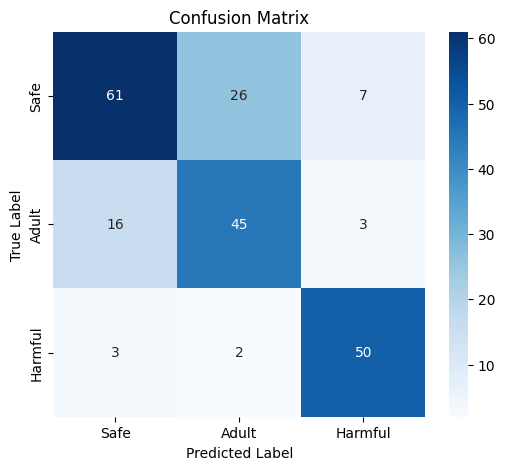

In [82]:
class_names = ['Safe', 'Adult', 'Harmful']  
plot_confusion_matrix(all_labels, all_preds, class_names)